In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('../data/games_of_all_time.csv')
model_data = data[['user_score','platform','genre','type','rating']] 

In [221]:
model_data = model_data.dropna()
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5936 entries, 0 to 8830
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_score  5936 non-null   float64
 1   platform    5936 non-null   object 
 2   genre       5936 non-null   object 
 3   type        5936 non-null   object 
 4   rating      5936 non-null   object 
dtypes: float64(1), object(4)
memory usage: 278.2+ KB


In [222]:
# exploding genre multiple values into individual rows
from ast import literal_eval
model_data['genre']=model_data['genre'].apply(literal_eval)
model_data = model_data.explode('genre', 'true')
# exploding platform multiple values into individual rows
model_data['platform']=model_data['platform'].apply(literal_eval)
model_data = model_data.explode('platform', 'true')

In [223]:
model_data['genre'].value_counts()

Action              2864
General             1885
Action Adventure    1333
Shooter             1096
Role-Playing        1019
                    ... 
Tank                   1
Videos                 1
Drag                   1
Text                   1
WWI                    1
Name: genre, Length: 166, dtype: int64

In [224]:
#should we remove the genre values which have less data ?
model_data = model_data[model_data.groupby('genre').genre.transform('count')>100].copy()

In [225]:
model_data['genre'].nunique()

53

In [226]:
model_data['platform'].value_counts()

pc                  5453
xbox-360            2571
playstation-4       2546
playstation-2       2247
playstation-3       2209
switch              1863
xbox                1335
xbox-one            1325
ds                  1094
wii                  970
psp                  936
gamecube             785
game-boy-advance     604
3ds                  314
playstation-vita     274
playstation          235
wii-u                164
playstation-5        111
nintendo-64           88
xbox-series-x         47
dreamcast             29
stadia                 5
Name: platform, dtype: int64

In [227]:
#should we replace multiple similar platform values to a single value e.g ps1,ps2 as ps
model_data['platform']=model_data['platform'].replace(['playstation-4','playstation-3','playstation-2',
                                                               'playstation-vita','playstation-5'],'playstation')
model_data['platform']=model_data['platform'].replace(['xbox-360','xbox-one','xbox-series-x'],'xbox')
model_data['platform']=model_data['platform'].replace(['wii-u'],'wii')

In [228]:
model_data['platform'].value_counts()

playstation         7622
pc                  5453
xbox                5278
switch              1863
wii                 1134
ds                  1094
psp                  936
gamecube             785
game-boy-advance     604
3ds                  314
nintendo-64           88
dreamcast             29
stadia                 5
Name: platform, dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

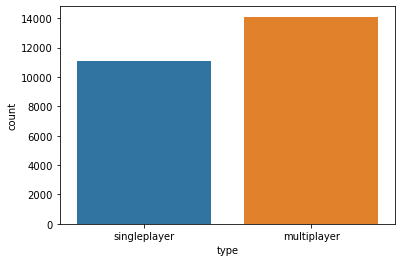

In [229]:
import seaborn as sns
sns.countplot(x='type', data=model_data)

<AxesSubplot:xlabel='rating', ylabel='count'>

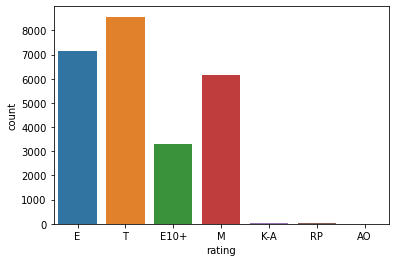

In [230]:
sns.countplot(x='rating', data=model_data)

In [231]:
#removing less frequent ratings
model_data = model_data.drop(model_data[model_data['rating'].isin(['K-A', 'RP', 'AO'])].index)

<AxesSubplot:xlabel='user_score', ylabel='count'>

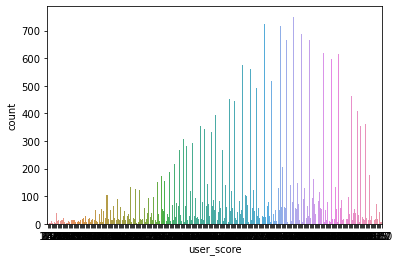

In [232]:
#user_score spread
sns.countplot(x='user_score', data=model_data)

In [233]:
#hot encoding
model_data= pd.get_dummies(model_data, columns=['platform','genre','type','rating'],prefix=['platform','genre','type','rating'])

In [234]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25155 entries, 0 to 28051
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_score                 25155 non-null  float64
 1   platform_3ds               25155 non-null  uint8  
 2   platform_dreamcast         25155 non-null  uint8  
 3   platform_ds                25155 non-null  uint8  
 4   platform_game-boy-advance  25155 non-null  uint8  
 5   platform_gamecube          25155 non-null  uint8  
 6   platform_nintendo-64       25155 non-null  uint8  
 7   platform_pc                25155 non-null  uint8  
 8   platform_playstation       25155 non-null  uint8  
 9   platform_psp               25155 non-null  uint8  
 10  platform_stadia            25155 non-null  uint8  
 11  platform_switch            25155 non-null  uint8  
 12  platform_wii               25155 non-null  uint8  
 13  platform_xbox              25155 non-null  uin

In [235]:
from sklearn.model_selection import train_test_split
X = model_data.drop(columns=['user_score'],axis=1).values
y = model_data[['user_score']].values

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [237]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#rf_model=RandomForestRegressor(n_estimators=1000,random_state=0)
X_train=X_train/256.
rf_pipe = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100,random_state=0))
rf_pipe.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=0))])

In [238]:
rf_pred = rf_pipe.predict(X_test)

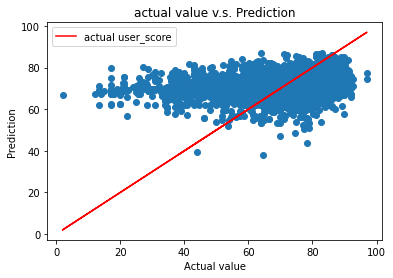

In [239]:
plt.scatter(y_test, rf_pred)
plt.plot(y_test, y_test, 'r', label='actual user_score')
plt.title("actual value v.s. Prediction")
plt.xlabel("Actual value")
plt.ylabel("Prediction")
plt.legend()
plt.show()

In [240]:
from sklearn import metrics

print('R2 score: ', rf_pipe.score(X_test, y_test))
mse = metrics.mean_squared_error(y_test, rf_pred)
print('MSE:', mse)

R2 score:  -0.009060072910424433
MSE: 171.1769492599751


In [241]:
genre_col = [col for col in model_data if col.startswith('genre')]
genre_col

['genre_2D',
 'genre_3D',
 'genre_Action',
 'genre_Action Adventure',
 'genre_Action RPG',
 'genre_Adventure',
 'genre_Alternative',
 'genre_Arcade',
 'genre_Automobile',
 'genre_Basketball',
 "genre_Beat-'Em-Up",
 'genre_Combat',
 'genre_Compilation',
 'genre_Console-style RPG',
 'genre_Driving',
 'genre_Fantasy',
 'genre_Fighting',
 'genre_First-Person',
 'genre_Football',
 'genre_GT / Street',
 'genre_General',
 'genre_Historic',
 'genre_Horror',
 'genre_Individual',
 'genre_Japanese-Style',
 'genre_Linear',
 'genre_Management',
 'genre_Miscellaneous',
 'genre_Modern',
 'genre_Music',
 'genre_Open-World',
 'genre_Platformer',
 'genre_Puzzle',
 'genre_Racing',
 'genre_Real-Time',
 'genre_Rhythm',
 'genre_Role-Playing',
 'genre_Sci-Fi',
 "genre_Shoot-'Em-Up",
 'genre_Shooter',
 'genre_Sim',
 'genre_Simulation',
 'genre_Soccer',
 'genre_Sports',
 'genre_Strategy',
 'genre_Survival',
 'genre_Tactical',
 'genre_Tactics',
 'genre_Team',
 'genre_Third-Person',
 'genre_Traditional',
 'genre

In [242]:
def getRecommendedGenre_ForGameCreation(col_index, platform, type, rating, model):
    most_popular_genre = ''
    user_score = 0

    col_len = len(col_index)
    test = np.zeros(len(col_index))
    test[col_index.get_loc(type)] = 1
    test[col_index.get_loc(rating)] = 1
    test[col_index.get_loc(platform)] = 1

    for g in genre_col:
        test[col_index.get_loc(g)] = 1

        predict_score = model.predict(test.reshape(1, col_len))
        print(f'%s: %d' % (g, predict_score))
        if (user_score < predict_score):
            user_score = predict_score
            most_popular_genre = g

        test[col_index.get_loc(g)] = 0

    return most_popular_genre

In [243]:
model_data_copy = model_data.drop(columns=['user_score'])
recommended_genre = getRecommendedGenre_ForGameCreation(
    model_data_copy.columns,'platform_gamecube',
    'type_singleplayer', 'rating_T', rf_pipe)
print(f'RandomForestRegressor model predict: %s\n' % recommended_genre)

genre_2D: 80
genre_3D: 73
genre_Action: 80
genre_Action Adventure: 74
genre_Action RPG: 81
genre_Adventure: 76
genre_Alternative: 80
genre_Arcade: 70
genre_Automobile: 77
genre_Basketball: 80
genre_Beat-'Em-Up: 66
genre_Combat: 75
genre_Compilation: 78
genre_Console-style RPG: 85
genre_Driving: 70
genre_Fantasy: 79
genre_Fighting: 80
genre_First-Person: 84
genre_Football: 81
genre_GT / Street: 76
genre_General: 70
genre_Historic: 81
genre_Horror: 83
genre_Individual: 72
genre_Japanese-Style: 79
genre_Linear: 80
genre_Management: 78
genre_Miscellaneous: 80
genre_Modern: 61
genre_Music: 80
genre_Open-World: 82
genre_Platformer: 77
genre_Puzzle: 80
genre_Racing: 65
genre_Real-Time: 81
genre_Rhythm: 81
genre_Role-Playing: 84
genre_Sci-Fi: 81
genre_Shoot-'Em-Up: 80
genre_Shooter: 83
genre_Sim: 80
genre_Simulation: 82
genre_Soccer: 80
genre_Sports: 66
genre_Strategy: 85
genre_Survival: 82
genre_Tactical: 71
genre_Tactics: 81
genre_Team: 72
genre_Third-Person: 78
genre_Traditional: 79
genre_T

In [244]:
import pickle

filename = 'q2_rf_model.sav'
pickle.dump(rf_pipe, open(filename, 'wb'))